# Big Data in Finance: Part II <BR><BR> Lecture Notes 4: Merge CRSP and Compustat 
    
**Instructor** <BR>
Kirsten Burr, kburr26@gsb.columbia.edu
    
**TA's:** <BR>
Meha Sadasivam, MSadasivam21@gsb.columbia.edu <BR>
Daheng Yang, dyang22@gsb.columbia.edu
    
<sub> Credit: lecture notes originally developed by Lira Mota

## Objective:
    
Create a final data set called "stock_annual" that has both crsp (permno/permco) and compustat (gvkey) identifiers.

## Set Up

In [1]:
#%% Packages 
import wrds
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time
from time import strptime, strftime

# Setups
pd.set_option("display.max_rows", 500) # max number or rows to be displayed 
%matplotlib inline 
plt.rcParams['figure.figsize'] = [10, 6]

In [2]:
db = wrds.Connection(wrds_username='khardnett')  # make sure to configure wrds connector before hand.

Loading library list...
Done


In [3]:
# Load Compustat and CRSP data. Data downloaded in lecture notes 2 and 3.
compa = pd.read_pickle('compa_annual.pkl')
crspm = pd.read_pickle('crsp_monthly.pkl')

## What is the difficulty with merging CRSP and Compustat?

In [4]:
print(crspm.columns)
print(compa.columns)

Index(['date', 'permno', 'permco', 'prc', 'vol', 'ret', 'retx', 'cfacpr',
       'cfacshr', 'comnam', 'dlret', 'dlretx', 'exchcd', 'naics', 'cusip',
       'ncusip', 'shrcd', 'shrout', 'siccd', 'ticker', 'retadj', 'me', 'mesum',
       'melag_nt', 'melag', 'rankyear', 'mdate', 'rf'],
      dtype='object')
Index(['gvkey', 'datadate', 'conm', 'tic', 'cusip', 'fyear', 'fyr', 'at',
       'capx', 'ceq', 'cogs', 'csho', 'dlc', 'dlcch', 'dltt', 'dp', 'ib',
       'itcb', 'lt', 'mib', 'naicsh', 'ni', 'prstkcc', 'pstk', 'pstkl',
       'pstkrv', 're', 'revt', 'sale', 'seq', 'sich', 'txdb', 'txdi', 'txditc',
       'wcapch', 'xint', 'xlr', 'xrd', 'xsga', 'se', 'ps', 'dt', 'be', 'cost',
       'op', 'opbe', 'at_lag', 'inv', 'fdiff', 'inv_capx'],
      dtype='object')


### Possibility: CUSIP

A CUSIP is a nine-digit numeric (e.g. 037833100 for Apple) or nine-character alphanumeric (e.g. 38259P508 for Google) code that identifies a North American financial security for the purposes of facilitating clearing and settlement of trades. The CUSIP was adopted as an American National Standard under Accredited Standards X9.6. The acronym, pronounced as "kyoo-sip," derives from Committee on Uniform Security Identification Procedures.

The CUSIP system is owned by the American Bankers Association and is operated by S&P Global Market Intelligence. The operating body, CUSIP Global Services (CGS), also serves as the national numbering agency (NNA) for North America, and the CUSIP serves as the National Securities Identification Number (NSIN) for products issued from both the United States and Canada. 

Source: Wikipedia 


In [5]:
crspm[['permno', 'date', 'comnam', 'ticker', 'cusip', 'ncusip']][(crspm.permno==90319)][-90:-80]

,permno,date,comnam,ticker,cusip,ncusip
2754175,90319,2016-07-29,ALPHABET INC,GOOGL,02079K30,02079K30
2761533,90319,2016-08-31,ALPHABET INC,GOOGL,02079K30,02079K30
2768883,90319,2016-09-30,ALPHABET INC,GOOGL,02079K30,02079K30
2776199,90319,2016-10-31,ALPHABET INC,GOOGL,02079K30,02079K30
2783518,90319,2016-11-30,ALPHABET INC,GOOGL,02079K30,02079K30
2790842,90319,2016-12-30,ALPHABET INC,GOOGL,02079K30,02079K30
2798144,90319,2017-01-31,ALPHABET INC,GOOGL,02079K30,02079K30
2805467,90319,2017-02-28,ALPHABET INC,GOOGL,02079K30,02079K30
2812800,90319,2017-03-31,ALPHABET INC,GOOGL,02079K30,02079K30
2820138,90319,2017-04-28,ALPHABET INC,GOOGL,02079K30,02079K30


In [6]:
compa[['gvkey', 'datadate', 'conm', 'tic', 'cusip']][(compa.tic=='GOOGL')]

,gvkey,datadate,conm,tic,cusip
403734,160329,2002-12-31,ALPHABET INC,GOOGL,02079K305
403723,160329,2003-12-31,ALPHABET INC,GOOGL,02079K305
403737,160329,2004-12-31,ALPHABET INC,GOOGL,02079K305
403738,160329,2005-12-31,ALPHABET INC,GOOGL,02079K305
403739,160329,2006-12-31,ALPHABET INC,GOOGL,02079K305
403741,160329,2007-12-31,ALPHABET INC,GOOGL,02079K305
403742,160329,2008-12-31,ALPHABET INC,GOOGL,02079K305
403743,160329,2009-12-31,ALPHABET INC,GOOGL,02079K305
403745,160329,2010-12-31,ALPHABET INC,GOOGL,02079K305
403746,160329,2011-12-31,ALPHABET INC,GOOGL,02079K305


### Possibility: Names or Ticker 

In [7]:
crspm_t = crspm[['permno','permco','date', 'comnam', 'ticker', 
                 'cusip', 'ncusip', 'prc', 'ret', 'retadj']][crspm.ticker=='T']

In [8]:
crspm_t[crspm_t.comnam=='AMERICAN TELEPHONE & TELEG CO'].sort_values('date').tail()

,permno,permco,date,comnam,ticker,cusip,ncusip,prc,ret,retadj
672865,10401,20103,1993-11-30,AMERICAN TELEPHONE & TELEG CO,T,00195750,03017710,54.625,-0.050000,-0.050000
680801,10401,20103,1993-12-31,AMERICAN TELEPHONE & TELEG CO,T,00195750,03017710,52.500,-0.032860,-0.032860
688790,10401,20103,1994-01-31,AMERICAN TELEPHONE & TELEG CO,T,00195750,03017710,56.750,0.080952,0.080952
696824,10401,20103,1994-02-28,AMERICAN TELEPHONE & TELEG CO,T,00195750,03017710,52.500,-0.074890,-0.074890
704931,10401,20103,1994-03-31,AMERICAN TELEPHONE & TELEG CO,T,00195750,03017710,51.250,-0.017524,-0.017524


In [9]:
crspm_t[crspm_t.comnam=='A T & T CORP'].sort_values('date').head()

,permno,permco,date,comnam,ticker,cusip,ncusip,prc,ret,retadj
713077,10401,20103,1994-04-29,A T & T CORP,T,00195750,00195710,51.250,0.000000,0.000000
721299,10401,20103,1994-05-31,A T & T CORP,T,00195750,00195710,54.625,0.065854,0.065854
729573,10401,20103,1994-06-30,A T & T CORP,T,00195750,00195710,54.375,0.001465,0.001465
737871,10401,20103,1994-07-29,A T & T CORP,T,00195750,00195710,54.625,0.004598,0.004598
746200,10401,20103,1994-08-31,A T & T CORP,T,00195750,00195710,54.625,0.000000,0.000000


[AT&T accquired by SBC](https://urldefense.proofpoint.com/v2/url?u=https-3A__investors.att.com_stockholder-2Dservices_cost-2Dbasis-2Dguide_worksheet_att-2Dcorp&d=DwMFAg&c=009klHSCxuh5AI1vNQzSO0KGjl4nbi2Q0M1QLJX9BeE&r=m3cgfvM0663JvpScJDvmDKbkzvoES7vfUoxkLJ1CA8Q&m=fz9D49wz2fY6QL72Wjv8RSevSyldgUBD4fISth0ehKBmmWCtm4EDaF7IW8gfnVML&s=Y03fuTsnnVYL7BQGwTVXf9UqnjXdvCC2q2Bn2PPtSRM&e=)

In [10]:
crspm_t[crspm_t.comnam=='A T & T INC'].sort_values('date')

,permno,permco,date,comnam,ticker,cusip,ncusip,prc,ret,retadj
1861158,66093,21645,2005-12-30,A T & T INC,T,00206R10,00206R10,24.49,-0.016861,-0.016861
1868121,66093,21645,2006-01-31,A T & T INC,T,00206R10,00206R10,25.95,0.073193,0.073193
1875069,66093,21645,2006-02-28,A T & T INC,T,00206R10,00206R10,27.59,0.063198,0.063198
1882009,66093,21645,2006-03-31,A T & T INC,T,00206R10,00206R10,27.04,-0.019935,-0.019935
1888945,66093,21645,2006-04-28,A T & T INC,T,00206R10,00206R10,26.21,-0.018399,-0.018399
1895894,66093,21645,2006-05-31,A T & T INC,T,00206R10,00206R10,26.06,-0.005723,-0.005723
1902895,66093,21645,2006-06-30,A T & T INC,T,00206R10,00206R10,27.89,0.070223,0.070223
1909885,66093,21645,2006-07-31,A T & T INC,T,00206R10,00206R10,29.99,0.087218,0.087218
1916864,66093,21645,2006-08-31,A T & T INC,T,00206R10,00206R10,31.13,0.038013,0.038013
1923859,66093,21645,2006-09-29,A T & T INC,T,00206R10,00206R10,32.56,0.045937,0.045937


## Query CRSP/Compustat merged table (annual or quarterly).

1. Output table is CRSP-centric with permno-datadate being the primary key.
2. Fiscal period end date must be within link date range.
3. WRDS SAS code can be found [here](https://wrds-www.wharton.upenn.edu/pages/wrds-research/applications/linking-databases/linking-crsp-and-compustat/).

## Many Linking Tables

In [11]:
crsp_tables = db.list_tables(library="crsp") 
crsp_tables = pd.DataFrame({'tables':crsp_tables}) # Transform libs to a Pandas data frame to have a better display.
crsp_tables[crsp_tables.tables.str.contains('ccm')]

,tables
19,ccm_lookup
20,ccm_qvards
21,ccmxpf_linktable
22,ccmxpf_lnkhist
23,ccmxpf_lnkrng
24,ccmxpf_lnkused


**CCMXPF_LNKHIST - Link History**


* CCMXPF_LNKHIST contains the historical and current links between GVKEY and LPERMNO/LPERMCO (previously known as NPERMN O/NPERMCO in old version CCM). 


* In addition, it includes the beginning and ending dates for links, the link types, and the primary issue marker, and liid codes (Compustat's secondary ID variable, IID).

[Source](https://wrds-www.wharton.upenn.edu/data-dictionary/crsp_q_ccm/ccmxpf_lnkhist/)

## Many Linking Types

In [12]:
db.describe_table(library="crsp", table="ccmxpf_lnkhist")

Approximately 117005 rows in crsp.ccmxpf_lnkhist.


,name,nullable,type,comment
0,gvkey,True,VARCHAR(6),None
1,linkprim,True,VARCHAR(1),None
2,liid,True,VARCHAR(3),None
3,linktype,True,VARCHAR(2),None
4,lpermno,True,DOUBLE_PRECISION,None
5,lpermco,True,DOUBLE_PRECISION,None
6,linkdt,True,DATE,None
7,linkenddt,True,DATE,None


## Download Data

In [13]:
sql = '''SELECT gvkey, lpermno as permno, lpermco as permco, linktype, linkdt, linkenddt
         FROM crsp.ccmxpf_lnkhist
         WHERE linktype IN ('LC', 'LU', 'LS') 
      ''' 

link_table = db.raw_sql(sql, date_cols=['linkdt', 'linkenddt'])

## Understading Linking Table

In [14]:
# Example 
link_table[link_table.permco==21645]

,gvkey,permno,permco,linktype,linkdt,linkenddt
9008,009899,66093.0,21645.0,LC,1984-02-16,NaT


In [15]:
# Example: LIBERTY MEDIA
link_table[link_table.permco==54311]

,gvkey,permno,permco,linktype,linkdt,linkenddt
14757,017010,13757.0,54311.0,LC,2013-01-14,2016-04-17
14758,017010,13758.0,54311.0,LC,2013-01-14,2016-04-17
14759,017010,14811.0,54311.0,LC,2014-07-24,2016-04-17
14760,017010,15998.0,54311.0,LC,2016-04-18,2017-12-31
14761,017010,15998.0,54311.0,LC,2018-01-01,NaT
14762,017010,15999.0,54311.0,LC,2016-04-18,NaT
14763,017010,16000.0,54311.0,LC,2016-04-18,2017-12-31
14764,017010,16000.0,54311.0,LC,2018-01-01,NaT
19337,027186,15996.0,54311.0,LC,2016-04-18,2017-12-31
19338,027186,15996.0,54311.0,LC,2018-01-01,2023-07-18


## Merge and Link

* Link type code. Each link is given a code describing the connection between the CRSP and Compustat data. 

* Values are:

    * LC – Link research complete. Standard connection between databases.
    * LU – Unresearched link to issue by CUSIP
    * LS – Link valid for this security only. Other CRSP PERMNOs with the same PERMCO will link to other GVKEYs.
    * LX – Link to a security that trades on another exchange system not included in CRSP data.
    * LD – Duplicate Link to a security. Another GVKEY/IID is a better link to that CRSP record.
    * LN – Primary link exists but Compustat does not have prices.
    * NR – No link available, confirmed by research
    * NU – No link available, not yet confirmed

In [16]:
link_table.linktype.value_counts()

linktype
LC    17013
LU    15993
LS     5158
Name: count, dtype: int64

In [17]:
compa.head()

,gvkey,datadate,conm,tic,cusip,fyear,fyr,at,capx,ceq,...,ps,dt,be,cost,op,opbe,at_lag,inv,fdiff,inv_capx
0,001001,1980-12-31,A & M FOOD SERVICES INC,AMFD.,000165100,1980,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,001001,1981-12-31,A & M FOOD SERVICES INC,AMFD.,000165100,1981,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2,001001,1982-12-31,A & M FOOD SERVICES INC,AMFD.,000165100,1982,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,001001,1983-12-31,A & M FOOD SERVICES INC,AMFD.,000165100,1983,12,14.080,3.367,7.823,...,0.0,0.000,7.823,23.508,1.887,0.241212,NaN,NaN,1.0,NaN
4,001001,1984-12-31,A & M FOOD SERVICES INC,AMFD.,000165100,1984,12,16.267,5.496,8.962,...,0.0,0.357,9.319,29.460,2.547,0.273313,14.08,0.155327,1.0,0.390341


In [18]:
df = pd.merge(compa, link_table, on=['gvkey'], how='inner') 
df

,gvkey,datadate,conm,tic,cusip,fyear,fyr,at,capx,ceq,...,opbe,at_lag,inv,fdiff,inv_capx,permno,permco,linktype,linkdt,linkenddt
0,001001,1980-12-31,A & M FOOD SERVICES INC,AMFD.,000165100,1980,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10015.0,6398.0,LU,1983-09-20,1986-07-31
1,001001,1981-12-31,A & M FOOD SERVICES INC,AMFD.,000165100,1981,12,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,10015.0,6398.0,LU,1983-09-20,1986-07-31
2,001001,1982-12-31,A & M FOOD SERVICES INC,AMFD.,000165100,1982,12,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,10015.0,6398.0,LU,1983-09-20,1986-07-31
3,001001,1983-12-31,A & M FOOD SERVICES INC,AMFD.,000165100,1983,12,14.080,3.367,7.823,...,0.241212,NaN,NaN,1.0,NaN,10015.0,6398.0,LU,1983-09-20,1986-07-31
4,001001,1984-12-31,A & M FOOD SERVICES INC,AMFD.,000165100,1984,12,16.267,5.496,8.962,...,0.273313,14.080,0.155327,1.0,0.390341,10015.0,6398.0,LU,1983-09-20,1986-07-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460146,351038,2022-12-31,QUOIN PHARMACEUTICALS LTD,QNRX,74907L300,2022,12,14.458,0.000,7.407,...,-1.332118,9.357,0.545153,1.0,NaN,16161.0,55612.0,LC,2021-10-29,NaT
460147,352262,2022-12-31,COOL COMPANY LTD,CLCO,G2415A113,2022,12,2058.061,353.506,646.557,...,0.208487,NaN,NaN,NaN,NaN,23773.0,59507.0,LC,2023-03-17,NaT
460148,353444,2021-12-31,HALEON PLC,HLN,405552100,2021,12,46650.099,308.735,35687.306,...,0.088484,NaN,NaN,NaN,NaN,23209.0,59330.0,LC,2022-07-22,NaT
460149,353444,2022-12-31,HALEON PLC,HLN,405552100,2022,12,41948.594,366.290,19677.222,...,0.150083,46650.099,-0.100782,1.0,0.007852,23209.0,59330.0,LC,2022-07-22,NaT


In [19]:
# Keep only link in the right range
df = df[(df.datadate >= df.linkdt) | (df.linkdt.isnull())]
df = df[(df.datadate <= df.linkenddt) | (df.linkenddt.isnull())]

In [20]:
df['permno'] = df['permno'].astype(int)
df['permco'] = df['permco'].astype(int)
df['datadate'] = pd.to_datetime(df['datadate'])

In [21]:
df.shape

(302425, 55)

In [22]:
compa.shape

(467080, 50)

<Axes: xlabel='fyear'>

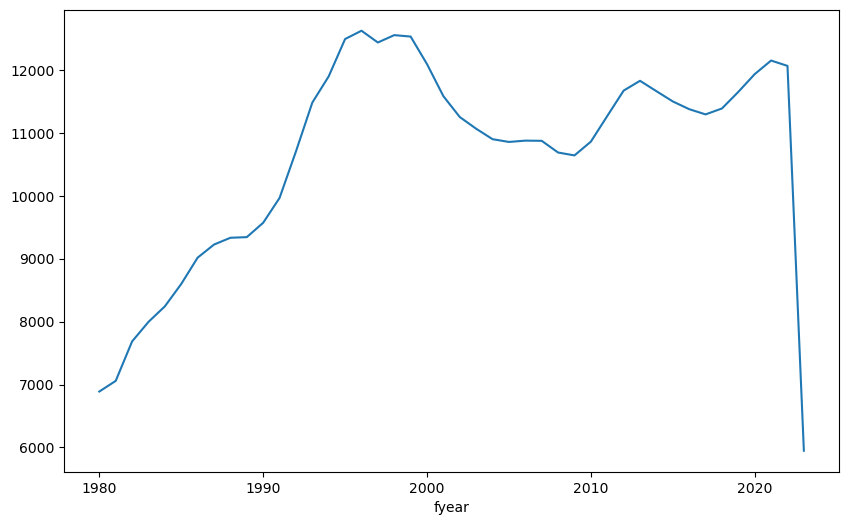

In [23]:
# Number of companies have declined since late 1990s
compa.groupby(['fyear']).gvkey.nunique().plot()

<Axes: xlabel='fyear'>

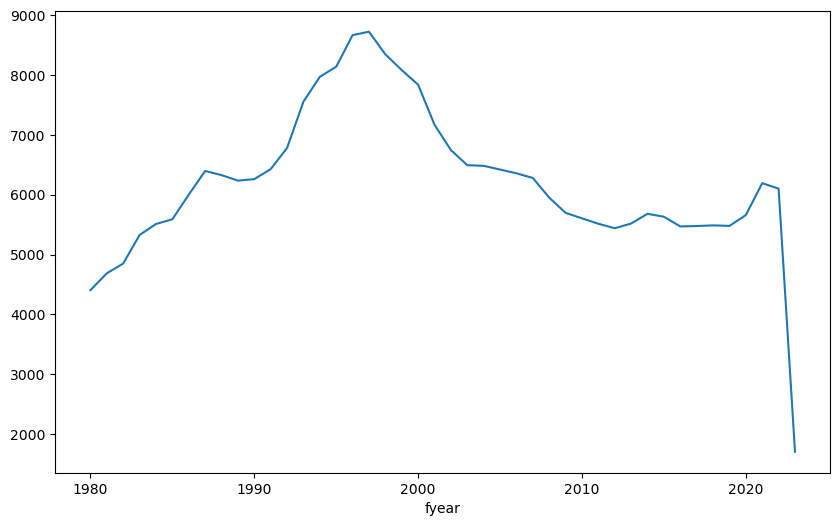

In [24]:
# So does the number of traded stocks
df.groupby(['fyear']).permco.nunique().plot()

* Why do we see a decline in the number of publicly listed stocks?
* Take a look at [Doidge, Karolyi, Stulz (2017)](https://www.sciencedirect.com/science/article/pii/S0304405X1630232X)

## Special Cases

In [25]:
# Should we have duplicated entries for (permco, datadate)?
print(df.duplicated(subset=['permco', 'datadate']).sum())

29242


In [26]:
df.groupby(['permno','datadate']).gvkey.nunique().max()

1

### Many PERMCOs for One GVKEY

In [27]:
df.groupby('gvkey').permco.nunique().max()

4

In [28]:
df.loc[df.gvkey==df.groupby('gvkey').permco.nunique().idxmax(), ['datadate', 'permno', 'permco','gvkey', 'conm', 'at']]

,datadate,permno,permco,gvkey,conm,at
317686,1995-12-31,81875,4388,032280,STARZ,2517.636
317693,1996-12-31,81875,4388,032280,STARZ,3058.952
317700,1997-12-31,81875,4388,032280,STARZ,5038.561
317707,1998-12-31,81875,4388,032280,STARZ,20348.000
317715,1999-12-31,86746,20103,032280,STARZ,58684.000
317722,2000-12-31,86746,20103,032280,STARZ,54268.000
317730,2001-12-31,89130,41998,032280,STARZ,48539.000
317737,2002-12-31,89130,41998,032280,STARZ,39685.000
317744,2003-12-31,89130,41998,032280,STARZ,54013.000
317751,2004-12-31,89130,41998,032280,STARZ,50181.000


### Many GVKEYs for one PERMCO

In [29]:
df[df['at'].notnull()].groupby('permco').gvkey.nunique().max()

5

In [30]:
pp = df[df['at'].notnull()].groupby('permco').gvkey.nunique().idxmax()
df.loc[df.permco==pp, ['datadate', 'permno', 'permco','gvkey', 'conm', 'at']].sort_values(['datadate'])

,datadate,permno,permco,gvkey,conm,at
382341,1994-12-31,81154,8243,118653,GENZYME TISSUE REPAIR,NaN
382342,1995-12-31,81154,8243,118653,GENZYME TISSUE REPAIR,NaN
167859,1996-12-31,10324,8243,012233,GENZYME CORP,1229.519
382343,1996-12-31,81154,8243,118653,GENZYME TISSUE REPAIR,42.593
167860,1997-12-31,10324,8243,012233,GENZYME CORP,1203.056
382344,1997-12-31,81154,8243,118653,GENZYME TISSUE REPAIR,56.818
381345,1998-12-31,86426,8243,117298,GENZYME MOLECULAR ONCOLOGY,35.952
382345,1998-12-31,81154,8243,118653,GENZYME TISSUE REPAIR,18.954
167861,1998-12-31,10324,8243,012233,GENZYME CORP,1646.307
382346,1999-12-31,81154,8243,118653,GENZYME TISSUE REPAIR,19.648


### Many GVKEYs for one PERMCO for the Same Date

In [31]:
df[df['at'].notnull()].groupby(['permco','datadate']).gvkey.nunique().max()

4

In [32]:
pp = df[df['at'].notnull()].groupby(['permco','datadate']).gvkey.nunique().idxmax()
pp

(8243, Timestamp('1999-12-31 00:00:00'))

In [33]:
df.loc[df.permco==8243, ['datadate', 'permno', 'permco','gvkey', 'conm', 'at']].sort_values(['datadate'])

,datadate,permno,permco,gvkey,conm,at
382341,1994-12-31,81154,8243,118653,GENZYME TISSUE REPAIR,NaN
382342,1995-12-31,81154,8243,118653,GENZYME TISSUE REPAIR,NaN
167859,1996-12-31,10324,8243,012233,GENZYME CORP,1229.519
382343,1996-12-31,81154,8243,118653,GENZYME TISSUE REPAIR,42.593
167860,1997-12-31,10324,8243,012233,GENZYME CORP,1203.056
382344,1997-12-31,81154,8243,118653,GENZYME TISSUE REPAIR,56.818
381345,1998-12-31,86426,8243,117298,GENZYME MOLECULAR ONCOLOGY,35.952
382345,1998-12-31,81154,8243,118653,GENZYME TISSUE REPAIR,18.954
167861,1998-12-31,10324,8243,012233,GENZYME CORP,1646.307
382346,1999-12-31,81154,8243,118653,GENZYME TISSUE REPAIR,19.648


In [34]:
df.loc[df.permco==54311, ['datadate', 'permno', 'permco','gvkey', 'conm', 'at']].sort_values(['datadate'])

,datadate,permno,permco,gvkey,conm,at
223981,2013-12-31,13757,54311,017010,LIBERTY MEDIA SIRIUSXM GROUP,34542.0
223982,2013-12-31,13758,54311,017010,LIBERTY MEDIA SIRIUSXM GROUP,34542.0
223989,2014-12-31,13757,54311,017010,LIBERTY MEDIA SIRIUSXM GROUP,31207.0
223990,2014-12-31,13758,54311,017010,LIBERTY MEDIA SIRIUSXM GROUP,31207.0
223991,2014-12-31,14811,54311,017010,LIBERTY MEDIA SIRIUSXM GROUP,31207.0
223997,2015-12-31,13757,54311,017010,LIBERTY MEDIA SIRIUSXM GROUP,29798.0
223998,2015-12-31,13758,54311,017010,LIBERTY MEDIA SIRIUSXM GROUP,29798.0
223999,2015-12-31,14811,54311,017010,LIBERTY MEDIA SIRIUSXM GROUP,29798.0
281483,2016-12-31,15997,54311,027186,ATLANTA BRAVES HOLDINGS INC,1548.0
281533,2016-12-31,14811,54311,027187,LIBERTY MEDIA FORMULA ONE,2995.0


## For next class

**(FI)nance (RE)search Python Tools: fire_pytools**

* To make our lives easier, we will use a fire_pytools package.

* Written by our alumni, Lira Mota
    - Download the package [here](https://bitbucket.org/liramota/fire_pytools/src)

* This is a collection of useful functions in finance research.
    - Direct download of CRSP and Compustat from WRDS server
    - Direct download of Ken French data library
    - Portfolio sorts tools
    - Replicate Fama and French factors